- 모두의 연구소 풀잎스쿨 - Deep Learning for Anomaly Detection 논문 리뷰 4주차 발표 코드

Paper: [Deep One-Class Classification](http://data.bit.uni-bonn.de/publications/ICML2018.pdf)

아래 코드를 참고
- [PyTorch Implementation of Deep SVDD](https://github.com/lukasruff/Deep-SVDD-PyTorch)
- [[바람돌이/딥러닝] Deep SVDD 논문 및 코드 리뷰](https://blog.naver.com/PostView.nhn?blogId=winddori2002&logNo=222142873877&categoryNo=32&parentCategoryNo=1&viewDate=&currentPage=1&postListTopCurrentPage=1&from=postView)

# Import Libs

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import matplotlib.pyplot as plt

import os
import numpy as np
import sys

In [2]:
# version check
torch.__version__

'1.1.0'

'1.1.0'

In [3]:
# version check
sys.version_info

sys.version_info(major=3, minor=7, micro=9, releaselevel='final', serial=0)

sys.version_info(major=3, minor=7, micro=9, releaselevel='final', serial=0)

In [4]:
cwd = os.getcwd() # get current path

In [5]:
# device setting
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

'cpu'

In [6]:
# for reproducibility
random.seed(1)
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

# MNIST Data Load

In [7]:
from lib.mnist import *

In [8]:
mymnist = MyMNIST()

In [9]:
mymnist.train_data_loader.batch_size # batch size

128

128

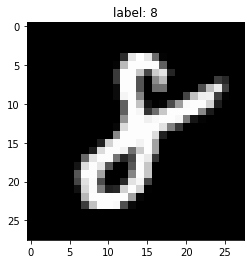

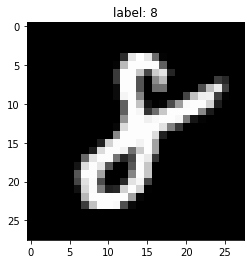

In [10]:
# check mnist data
for X, Y in mymnist.train_data_loader:
    r = random.randint(0, mymnist.train_data_loader.batch_size)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    ax.imshow(X[r].reshape(28,28), cmap = 'gray')
    ax.set_title('label: {}'.format(Y[r]))
    plt.show()
    break
    

# Autoencoder

In [11]:
from lib.networks import *

In [12]:
autoencoder = AE()

In [13]:
autoencoder

AE(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(8, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
  (conv2): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn2): BatchNorm2d(4, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
  (fc1): Linear(in_features=196, out_features=32, bias=False)
  (deconv1): ConvTranspose2d(2, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn3): BatchNorm2d(4, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
  (deconv2): ConvTranspose2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3), bias=False)
  (bn4): BatchNorm2d(8, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
  (deconv3): ConvTranspose2d(8, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
)

AE(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(8, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
  (conv2): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn2): BatchNorm2d(4, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
  (fc1): Linear(in_features=196, out_features=32, bias=False)
  (deconv1): ConvTranspose2d(2, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn3): BatchNorm2d(4, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
  (deconv2): ConvTranspose2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3), bias=False)
  (bn4): BatchNorm2d(8, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
  (deconv3): ConvTranspose2d(8, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
)

check weights before training

In [14]:
autoencoder.conv1.weight.data[0] # init weights

tensor([[[-0.0451,  0.1711,  0.1526,  0.1388, -0.0555],
         [ 0.1929, -0.0180, -0.1085, -0.1262,  0.1290],
         [-0.0484,  0.0050,  0.0810,  0.1887,  0.1327],
         [-0.0088,  0.0123, -0.0187,  0.1024, -0.1708],
         [ 0.0338, -0.1920, -0.0759,  0.0942, -0.1710]]])

tensor([[[-0.0451,  0.1711,  0.1526,  0.1388, -0.0555],
         [ 0.1929, -0.0180, -0.1085, -0.1262,  0.1290],
         [-0.0484,  0.0050,  0.0810,  0.1887,  0.1327],
         [-0.0088,  0.0123, -0.0187,  0.1024, -0.1708],
         [ 0.0338, -0.1920, -0.0759,  0.0942, -0.1710]]])

In [15]:
epochs = 1
learning_rate = 1e-3

In [16]:
criterion = nn.MSELoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [17]:
%%time
autoencoder.train() # train setting

total_batch = len(mymnist.train_data_loader)
print('Learning started. It takes sometime.')
for epoch in range(epochs):
    avg_cost = 0

    for X, Y in mymnist.train_data_loader:
        X = X.to(device)

        optimizer.zero_grad()
        X_hat = autoencoder(X)
        cost = criterion(X_hat, X)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.
Learning started. It takes sometime.
[Epoch:    1] cost = 0.0420985781
Learning Finished!
Wall time: 1min 2s
[Epoch:    1] cost = 0.0420985781
Learning Finished!
Wall time: 1min 2s


check after training

In [18]:
autoencoder.conv1.weight.data[0]

tensor([[[ 0.0043,  0.2008,  0.1127,  0.1232, -0.0578],
         [ 0.2461, -0.0011, -0.1726, -0.1586,  0.1099],
         [-0.0116, -0.0360,  0.0271,  0.1503,  0.1194],
         [-0.0091, -0.0086, -0.0428,  0.0840, -0.1692],
         [ 0.0152, -0.1937, -0.0887,  0.0846, -0.1583]]])

tensor([[[ 0.0043,  0.2008,  0.1127,  0.1232, -0.0578],
         [ 0.2461, -0.0011, -0.1726, -0.1586,  0.1099],
         [-0.0116, -0.0360,  0.0271,  0.1503,  0.1194],
         [-0.0091, -0.0086, -0.0428,  0.0840, -0.1692],
         [ 0.0152, -0.1937, -0.0887,  0.0846, -0.1583]]])

# DeepSVDD Network

In [19]:
deep_svdd = DeepSVDDNet(autoencoder)

In [20]:
deep_svdd

DeepSVDDNet(
  (net): AE(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (bn1): BatchNorm2d(8, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
    (conv2): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (bn2): BatchNorm2d(4, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
    (fc1): Linear(in_features=196, out_features=32, bias=False)
    (deconv1): ConvTranspose2d(2, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (bn3): BatchNorm2d(4, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
    (deconv2): ConvTranspose2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3), bias=False)
    (bn4): BatchNorm2d(8, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
    (deconv3): ConvTranspose2d(8, 1, kernel_size=(5, 5), stride=(1, 1), paddi

DeepSVDDNet(
  (net): AE(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (bn1): BatchNorm2d(8, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
    (conv2): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (bn2): BatchNorm2d(4, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
    (fc1): Linear(in_features=196, out_features=32, bias=False)
    (deconv1): ConvTranspose2d(2, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (bn3): BatchNorm2d(4, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
    (deconv2): ConvTranspose2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3), bias=False)
    (bn4): BatchNorm2d(8, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
    (deconv3): ConvTranspose2d(8, 1, kernel_size=(5, 5), stride=(1, 1), paddi

check weights after update

In [21]:
deep_svdd.net.conv1.weight.data[0]

tensor([[[ 0.0043,  0.2008,  0.1127,  0.1232, -0.0578],
         [ 0.2461, -0.0011, -0.1726, -0.1586,  0.1099],
         [-0.0116, -0.0360,  0.0271,  0.1503,  0.1194],
         [-0.0091, -0.0086, -0.0428,  0.0840, -0.1692],
         [ 0.0152, -0.1937, -0.0887,  0.0846, -0.1583]]])

tensor([[[ 0.0043,  0.2008,  0.1127,  0.1232, -0.0578],
         [ 0.2461, -0.0011, -0.1726, -0.1586,  0.1099],
         [-0.0116, -0.0360,  0.0271,  0.1503,  0.1194],
         [-0.0091, -0.0086, -0.0428,  0.0840, -0.1692],
         [ 0.0152, -0.1937, -0.0887,  0.0846, -0.1583]]])

In [22]:
from lib.DeepSVDDTrainer import *

In [23]:
deep_svdd_trainer = DeepSVDDTrainer(deep_svdd, device)

In [24]:
deep_svdd_trainer.init_center_c(mymnist.train_data_loader, device)

tensor([-1.5565,  2.2084,  1.6957, -1.3035,  0.1000,  0.9375,  2.3738, -1.1158,
         1.2410,  2.6203,  2.0333, -1.2435,  0.9519,  0.6849,  1.9140,  0.2618,
        -0.5862,  0.9607,  3.4149, -1.3062, -0.1000,  1.0939,  1.5143,  0.8905,
        -2.4483, -0.8450,  0.6553,  0.1807, -1.5275,  0.4098,  0.9791,  3.2228])

tensor([-1.5565,  2.2084,  1.6957, -1.3035,  0.1000,  0.9375,  2.3738, -1.1158,
         1.2410,  2.6203,  2.0333, -1.2435,  0.9519,  0.6849,  1.9140,  0.2618,
        -0.5862,  0.9607,  3.4149, -1.3062, -0.1000,  1.0939,  1.5143,  0.8905,
        -2.4483, -0.8450,  0.6553,  0.1807, -1.5275,  0.4098,  0.9791,  3.2228])

In [25]:
deep_svdd_trainer.c.shape

torch.Size([32])

torch.Size([32])

In [30]:
normal_class = 0

In [31]:
deep_svdd_trainer.train(normal_class, mymnist.train_data_loader, device, epochs = 1)

[Epoch:    1] cost = 0.415392665
[Epoch:    1] cost = 0.415392665


(tensor(0),
 tensor([-1.5565,  2.2084,  1.6957, -1.3035,  0.1000,  0.9375,  2.3738, -1.1158,
          1.2410,  2.6203,  2.0333, -1.2435,  0.9519,  0.6849,  1.9140,  0.2618,
         -0.5862,  0.9607,  3.4149, -1.3062, -0.1000,  1.0939,  1.5143,  0.8905,
         -2.4483, -0.8450,  0.6553,  0.1807, -1.5275,  0.4098,  0.9791,  3.2228]))

(tensor(0),
 tensor([-1.5565,  2.2084,  1.6957, -1.3035,  0.1000,  0.9375,  2.3738, -1.1158,
          1.2410,  2.6203,  2.0333, -1.2435,  0.9519,  0.6849,  1.9140,  0.2618,
         -0.5862,  0.9607,  3.4149, -1.3062, -0.1000,  1.0939,  1.5143,  0.8905,
         -2.4483, -0.8450,  0.6553,  0.1807, -1.5275,  0.4098,  0.9791,  3.2228]))

In [32]:
label_score = deep_svdd_trainer.test(0, mymnist.test_data_loader, device)

# AUC 계산

In [33]:
labels, scores = zip(*label_score)
labels = np.array(labels)
scores = np.array(scores)

In [39]:
for_auc_label = list(map(lambda x: 0 if x==normal_class else 1, labels))

In [40]:
import pandas as pd

In [41]:
R_in = scores[np.where(labels==normal_class)[0]]
R_out = scores[np.where(labels!=normal_class)[0]]

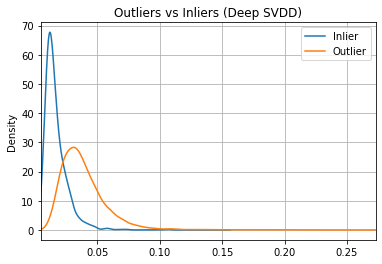

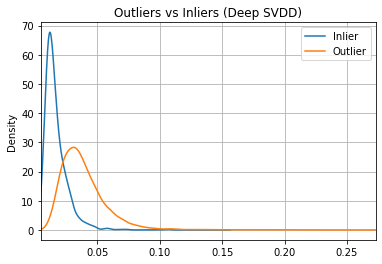

In [43]:
in_ = pd.DataFrame(R_in, columns=['Inlier'])
out_ = pd.DataFrame(R_out, columns=['Outlier'])


fig, ax = plt.subplots()
in_.plot.kde(ax=ax, legend=True, title='Outliers vs Inliers (Deep SVDD)')
out_.plot.kde(ax=ax, legend=True)
plt.xlim(in_.min()[0], out_.max()[0])
ax.grid(axis='x')
ax.grid(axis='y')

plt.show()